In [1]:
import torch
import numpy as np

def c2m(A):
    #complex number to matrix
    Cre = torch.from_numpy(np.real(A))
    Cim = torch.from_numpy(np.imag(A))
    return torch.cat((Cre.unsqueeze(0),Cim.unsqueeze(0)),0)

def mcat(A,B):
    Cre = A
    Cim = B
    return torch.cat((Cre.unsqueeze(0),Cim.unsqueeze(0)),0)

def cmul(A,B):
    # complex matrix multiplication without scalar
    Cre = torch.mm(A[0,:],B[0,:]) - torch.mm(A[1,:],B[1,:])
    Cim = torch.mm(A[0,:],B[1,:]) + torch.mm(A[1,:],B[0,:])
    return torch.cat((Cre.unsqueeze(0),Cim.unsqueeze(0)),0)

def cmul1(a,B):
    # multiple the scalar and matrix
    Cre = a[0] * B[0, :] - a[1] * B[1, :]
    Cim = a[0] * B[1, :] + a[1] * B[0, :]
    return torch.cat((Cre.unsqueeze(0),Cim.unsqueeze(0)),0)

def cmul2(a,b):
    # scalar multiplication
    cre = a[0] * b[0] - a[1] * b[1]
    cim = a[0] * b[1] + a[1] * b[0]

    return torch.cat((cre.unsqueeze(0),cim.unsqueeze(0)),0)

def conjT(A):
    # Conjugate transpose of the matrix and vector
    Bre = torch.transpose(A[0,:],0,1)
    Bim = torch.transpose(-A[1,:],0,1)
    return torch.cat((Bre.unsqueeze(0),Bim.unsqueeze(0)),0)

def conj(a):
    # conjugate of complex numbers
    bre = a[0]
    bim = -a[1]
    return torch.cat((bre.unsqueeze(0),bim.unsqueeze(0)),0)


def cinv(A):
    # inversion of complex matrix
    Cre = torch.inverse(A[0,:]+torch.mm(A[1,:],torch.mm(torch.inverse(A[0,:]),A[1,:])))
    Cim = -torch.mm(torch.mm(torch.inverse(A[0,:]),A[1,:]),Cre)
    return torch.cat((Cre.unsqueeze(0), Cim.unsqueeze(0)), 0)

def cdiag(a):
    Are = torch.diag(a[0,:])
    Aim = torch.diag(a[1,:])
    return torch.cat((Are.unsqueeze(0), Aim.unsqueeze(0)), 0)


def cdiv(A):

    Are = torch.diag(torch.div(torch.diag(A[0,:]),torch.diag(A[0,:])**2+torch.diag(A[1,:])**2))
    Aim = torch.diag(torch.div(-torch.diag(A[1,:]),torch.diag(A[0,:])**2+torch.diag(A[1,:])**2))
    return torch.cat((Are.unsqueeze(0), Aim.unsqueeze(0)), 0)

def cdiv1(B,a):
    # division of scalar
    de = (a[0]**2+a[1]**2)
    Are = a[0]/de * B[0,:] + a[1]/de * B[1,:]
    Aim = a[0]/de * B[1,:] - a[1]/de * B[0,:]
    return torch.cat((Are.unsqueeze(0), Aim.unsqueeze(0)), 0)

def c1div(a):
    # the bottom of scalar
    de = (a[0]**2+a[1]**2)
    Are = a[0]/de
    Aim = -a[1]/de
    return torch.cat((Are.unsqueeze(0), Aim.unsqueeze(0)), 0)

def cdiv2(a,b):
    # division of scalar
    return cmul2(a,c1div(b))

def cdet(A):

    return A[0,0,0]*A[0,1,1]-A[1,1,1]*A[1,0,0]-A[0,1,0]*A[0,0,1]+A[1,1,0]*A[1,0,1] 

def laplace_temp(A, idx, jdx):
    n = A.size(1)-1
    A_real = torch.zeros((n,n))
    A_imag = torch.zeros((n,n))
    index_x = 0
    index_y = 0
    for i in range(n+1):
        index_y = 0
        for j in range(n+1):        
            if (i!=idx)&(j!=jdx):
                A_real[index_x,index_y] = A[0,i,j]
                A_imag[index_x,index_y] = A[1,i,j]
                index_y += 1
        if (i!=idx):
            index_x += 1
    return torch.cat((A_real.unsqueeze(0),A_imag.unsqueeze(0)),0)

def complex_det(A):
    # det
    n = A.size(1)
    if n == 1:
        return torch.cat((A[0,0,0].unsqueeze(0),A[1,0,0].unsqueeze(0)),0)
    else: 
        det = torch.tensor([0., 0.])
        for j in range(n):
            det += (-1)**((2+j)%2)*cmul2(mcat(A[0,0,j],A[1,0,j]),complex_det(laplace_temp(A,0,j)))
        return det


def stacking(A):
    Ar = torch.from_numpy(np.real(A))
    print(Ar.ndim)
    Ai = torch.from_numpy(np.imag(A))
    A = torch.cat((Ar.unsqueeze(0), Ai.unsqueeze(0)), 0)
    return A

def c2mm(A):
    a = torch.zeros((2, np.size(A)))
    a[0] = torch.from_numpy(np.real(A))
    a[1] = torch.from_numpy(np.imag(A))
    return a


In [671]:
import numpy as np
import math
import torch

Es_16qam = 10
mapping_table_16qam = {
    (1,0,1,0) : -3-3j,
    (1,0,1,1) : -3-1j,
    (1,0,0,1) : -3+1j,
    (1,0,0,0) : -3+3j,
    (1,1,1,0) : -1-3j,
    (1,1,1,1) : -1-1j,
    (1,1,0,1) : -1+1j,
    (1,1,0,0) : -1+3j,
    (0,1,1,0) : 1-3j,
    (0,1,1,1) : 1-1j,
    (0,1,0,1) : 1+1j,
    (0,1,0,0) : 1+3j,
    (0,0,1,0) : 3-3j,
    (0,0,1,1) : 3-1j,
    (0,0,0,1) : 3+1j,
    (0,0,0,0) : 3+3j,
}

Es_qpsk = 2
mapping_table_qpsk = {
    (0,0) :  1+1j,
    (0,1) :  1-1j,
    (1,0) : -1+1j,
    (1,1) : -1-1j,
}

bits_per_digit = 9

demapping_table_16qam = {v : k for k, v in mapping_table_16qam.items()}
demapping_table_qpsk = {v : k for k, v in mapping_table_qpsk.items()}


def SVD_Precoding(H, P, d):
    U,D,V = np.linalg.svd(H, full_matrices=True)
    W_svd = V.conj().T[:,:d]
    M_svd = U

    W_svd_norm = np.sqrt(np.trace(W_svd.dot(W_svd.conj().T)))   #power norm
    W_svd = W_svd * np.sqrt(P) / W_svd_norm
    return W_svd, D, M_svd
    
def SignalNorm(signal, P, mod_type=None):
    signal_power = np.mean(abs(signal**2))
    print('signal_power:', signal_power)
    if mod_type is not None:
        if mod_type=='QPSK':
            return signal / np.sqrt(Es_qpsk) 
        elif mod_type=='16QAM':
            return signal / np.sqrt(Es_16qam)
    else:
        return signal * P / np.sqrt(signal_power)

def SignalDenorm(signal, P, mod_type=None):
    signal_power = np.mean(abs(signal**2))
    if mod_type is not None:
        if mod_type=='QPSK':
            return signal * np.sqrt(Es_qpsk)
        elif mod_type=='16QAM':
            return signal * np.sqrt(Es_16qam)
    else:
        return signal * math.sqrt(P) / math.sqrt(signal_power)

def cal_mse(A, B):
    if A.shape==B.shape:
        return np.sum((A-B)**2)/len(A.flatten())
    elif (len(A.flatten())==len(B.flatten())):
        return np.sum((A-B.reshape(A.shape))**2)/len(A.flatten())
    else:
        raise ValueError("The shape is different")

def cal_nmse(sparse_gt, sparse_pred):
    # Calculate the NMSE
    power_gt = sparse_gt[:, 0, :, :] ** 2 + sparse_gt[:, 1, :, :] ** 2
    difference = sparse_gt - sparse_pred
    mse = difference[:, 0, :, :] ** 2 + difference[:, 1, :, :] ** 2
    nmse = 10 * torch.log10((mse.sum(dim=[1, 2]) / power_gt.sum(dim=[1, 2])).mean())
    return nmse



def cal_mse_tensor(A, B):
    if A.shape==B.shape:
        return torch.sum((A-B)**2)/len(A.flatten())
    elif (len(A.flatten())==len(B.flatten())):
        return torch.sum((A-B.reshape(A.shape))**2)/len(A.flatten())
    else:
        raise ValueError("The shape is different")



class MIMO_Channel_Tensor():
    def __init__(self, Nr=2, Nt=4, d=2, K=1, P=1, device=None):
        # Base configs
        self.Nt = Nt   # transmit antenna
        self.K = K     # users
        self.Nr = Nr   # receive antenna
        self.d = d     # data streams  ** d <= min(Nt/K, Nr)  **
        self.P = P     # power

        self.device = device
        # mmWave configs
        # Nt = 32         # T antennas
        # Nr = 16         # R antennas
        self.NtRF = 4        # RF chains at the transmitter
        self.NrRF = 4        # RF chains at the receiver
        self.Ncl = 4         # clusters
        self.Nray = 6        # ray
        self.sigma_h = 0.3   # gain
        self.Tao = 0.001     # delay
        self.fd = 3          # maximum Doppler shift

    def Trans_Procedure_group(self, Tx_sig, H, V, D, U, snr=20):
        sigma2 = self.P * 10**(-snr/10) 
        total_num = len(Tx_sig.flatten())
        shape = Tx_sig.shape
        tx_times = int(total_num/self.d/2)
        symbol_group = Tx_sig.flatten().reshape(self.d, tx_times, 2).to(self.device)
        symbol_y = torch.zeros_like(symbol_group).to(self.device)
        symbol_trans = symbol_group[:,:,0] + 1j*symbol_group[:,:,1]

        symbol_trans = SignalNorm_tensor(symbol_trans, self.P)
        print((np.sqrt(abs(np.sum(symbol_trans.numpy()**2)))))
        noise = math.sqrt(sigma2/2) * (torch.randn(self.K*self.Nr, tx_times)+1j*torch.randn(self.K*self.Nr, tx_times)).to(self.device)
        y = torch.mm(torch.mm(H,V),symbol_trans)
        y_de = torch.mm(torch.mm(torch.diag(1/D)+1j*0,(U.conj().T)),y) + noise
        y_de_group = y_de[:self.d]
        symbol_y[:,:,0] = torch.real(SignalNorm_tensor(y_de_group, self.P))
        symbol_y[:,:,1] = torch.imag(SignalNorm_tensor(y_de_group, self.P))
        return symbol_y.reshape(shape)

    def Trans_Procedure_element(self, Tx_sig, H, V, D, U, snr=20):
        sigma2 = self.P * 10**(-snr/10) 
        total_num = len(Tx_sig.flatten())
        shape = Tx_sig.shape
        tx_times = int(total_num/self.d/2)
        symbol_group = Tx_sig.flatten().reshape(tx_times, self.d, 1, 2).to(self.device)
        symbol_y = torch.zeros_like(symbol_group).to(self.device)
        symbol_trans = symbol_group[:,:,:,0] + 1j*symbol_group[:,:,:,1]
        symbol_trans = SignalNorm_tensor(symbol_trans, self.P).to(self.device)
        y_de_group = (torch.zeros((tx_times, self.d, 1))+1j*0).to(self.device)
    
        for i in range(tx_times):
            symbol_x = symbol_trans[i,:,:]
            noise = math.sqrt(sigma2/2) * (torch.randn(self.K*self.Nr, 1)+1j*torch.randn(self.K*self.Nr, 1)).to(self.device)
            y= torch.mm(torch.mm(H,V),symbol_x) + noise
            y_de = torch.mm(torch.mm(torch.diag(1/D)+1j*0,(U.conj().T)),y) 
            y_de = y_de[:self.d]
            y_de_group[i] = y_de
        symbol_y[:,:,:,0] = torch.real(SignalNorm_tensor(y_de_group, self.P))
        symbol_y[:,:,:,1] = torch.imag(SignalNorm_tensor(y_de_group, self.P))
        return symbol_y.reshape(shape)

    def Circular_Gaussian(self, Tx_sig, snr=10, Group_enable=True):
        H_raw = 1/math.sqrt(2)* (torch.randn((self.Nr, self.Nt))+1j*torch.randn(self.Nr, self.Nt))    # Nr * Nt
        H_raw = torch.tensor(H_raw).to(self.device)
        sigmaH = self.P * 10**(-snr/10) 
        H_quan = H_raw + math.sqrt(sigmaH/2)* (torch.randn(self.Nr, self.Nt)+1j*torch.randn(self.Nr, self.Nt)).to(self.device)
        # H_quan.to(self.device)
        V,_,_ = SVD_Precoding_tensor(H_quan, self.P, self.d)
        U,D,_ = torch.linalg.svd(H_raw, full_matrices=False)
        if Group_enable:
            return self.Trans_Procedure_group(Tx_sig, H_raw, V, D, U, snr)
        else:
            return self.Trans_Procedure_element(Tx_sig, H_raw, V, D, U, snr)
    
    def mmwave_MIMO(self, Tx_sig, snr=10, Group_enable=True):
        def theta(N, Seed=100):
            phi = np.zeros(self.Ncl*self.Nray)         # azimuth AoA and AoD
            a = np.zeros((self.Ncl*self.Nray, N, 1), dtype=complex)

            for i in range(self.Ncl*self.Nray):
                phi[i] = np.random.uniform(-np.pi/3, np.pi/3)
            f = 0
            for j in range(self.Ncl*self.Nray):
                f += 1
                for z in range(N):
                    a[j][z] = np.exp(1j * np.pi * z * np.sin(phi[f-1]))
            PHI = phi.reshape(self.Ncl*self.Nray)
            return a/np.sqrt(N), PHI
        
        def H_gen(Seed=100):
            HH = np.zeros((self.Nr, self.Nt))
            # complex gain
            alpha_h = np.random.normal(0, self.sigma_h, (self.Ncl*self.Nray)) + 1j*np.random.normal(0, self.sigma_h, (self.Ncl*self.Nray))
            # receive and transmit array response vectors
            ar, ThetaR = theta(self.Nr, Seed+10000)
            at, ThetaT = theta(self.Nt, Seed)
            H = np.zeros((self.Nr, self.Nt), dtype=complex)
            fff = 0
            for i in range(self.Ncl):
                for j in range(self.Nray):
                    H += alpha_h[fff] * np.dot(ar[fff], np.conjugate(at[fff]).T)
                    # H += alpha_h[fff] * np.dot(ar[fff], np.conjugate(at[fff]).T)*np.exp(1j*2*np.pi*Tao*fd*np.cos(ThetaR[fff]))    # channel with delay
                    fff += 1
            H = np.sqrt(self.Nt * self.Nr / self.Ncl * self.Nray) * H
            # H = c2m(H)
            return torch.tensor(H)
        H_raw = H_gen()   # Nr * Nt
        sigmaH = 0 * 10**(-snr/10) 
        H_quan = H_raw + math.sqrt(sigmaH/2)* (torch.randn(self.Nr, self.Nt)+1j*torch.randn(self.Nr, self.Nt))
        H_raw= H_raw.to(torch.complex64)
        H_quan = H_quan.to(torch.complex64)
 
        V,_,_ = SVD_Precoding_tensor(H_quan, self.P, self.d)
        U,D,_ = torch.linalg.svd(H_raw, full_matrices=False)
        x1 = self.Trans_Procedure_group(Tx_sig, H_raw, V, D, U, snr)
    
        H_quan = H_quan.numpy()
        H_raw = H_raw.numpy()
    
        V,_,_ = SVD_Precoding(H_quan, self.P, self.d)
        U,D,_ = np.linalg.svd(H_raw, full_matrices=False)
        x2 = self.Trans_Procedure_numpy(Tx_sig.numpy(), H_raw, V, D, U, snr)

        return x1, x2
    
    def Trans_Procedure_numpy(self, Tx_sig, H, V, D, U, snr=20):
        sigma2 = self.P * 10**(-snr/10) 
        total_num = len(Tx_sig.flatten())
        shape = Tx_sig.shape
        tx_times = int(total_num/self.d/2)
        symbol_group = Tx_sig.flatten().reshape(self.d, tx_times, 2)
        symbol_y = np.zeros_like(symbol_group)
        symbol_trans = symbol_group[:,:,0] + 1j*symbol_group[:,:,1]
        print((np.sqrt(abs(np.sum(symbol_trans**2)))))
        symbol_trans = SignalNorm(symbol_trans, self.P)

        print((np.sqrt(abs(np.sum(symbol_trans**2)))))

        y_de_group = np.zeros((self.d, tx_times), dtype=complex)
        symbol_x = symbol_trans

        noise = np.sqrt(sigma2/2) * (np.random.randn(self.K*self.Nr, tx_times)+1j*np.random.randn(self.K*self.Nr, tx_times)) 
        y= H.dot(V).dot(symbol_x) + noise    # y = HVx+n
        y_de = np.diag(1/D).dot(U.conj().T).dot(y) / self.P
        y_de = y_de[:self.d]
        y_de_group = y_de
        symbol_y[:,:,0] = np.real(SignalNorm(y_de_group, self.P))
        symbol_y[:,:,1] = np.imag(SignalNorm(y_de_group, self.P))
        return symbol_y.reshape(shape)
    

    def Sim_Quan(self, Tx_sig, H_raw=None, H_quan=None, snr=20, Group_enable=True):
    
        H_raw = H_raw[0] + 1j*H_raw[1]
        H_raw = torch.tensor(H_raw).to(self.device)
        H_quan = H_quan[0] + 1j*H_quan[1]
        H_quan = torch.tensor(H_quan).to(self.device)

        V,_,_ = SVD_Precoding_tensor(H_quan, self.P, self.d)
        U,D,_ = torch.linalg.svd(H_raw, full_matrices=False)
        if Group_enable:
            return self.Trans_Procedure_group(Tx_sig, H_raw, V, D, U, snr)
        else:
            return self.Trans_Procedure_element(Tx_sig, H_raw, V, D, U, snr)

def SignalNorm_tensor(signal, P, mod_type=None):
    signal_power = torch.mean(abs(signal**2))
    print('signal_power_tensor',signal_power)
    if mod_type is not None:
        if mod_type=='QPSK':
            return signal / torch.sqrt(Es_qpsk) 
        elif mod_type=='16QAM':
            return signal / torch.sqrt(Es_16qam)
    else:
        return signal * P / torch.sqrt(signal_power)

def SignalDenorm_tensor(signal, P, mod_type=None):
    signal_power = torch.mean(abs(signal**2))
    if mod_type is not None:
        if mod_type=='QPSK':
            return signal * torch.sqrt(Es_qpsk)
        elif mod_type=='16QAM':
            return signal * torch.sqrt(Es_16qam)
    else:
        return signal * math.sqrt(P) / math.sqrt(signal_power)

def SVD_Precoding_tensor(H, P, d):
    U,D,V = torch.linalg.svd(H, full_matrices=True)
    W_svd = V.conj().T[:,:d]
    M_svd = U

    W_svd_norm = torch.sqrt(torch.trace(torch.mm(W_svd,W_svd.conj().T)))   #power norm
    W_svd = W_svd * np.sqrt(P) / W_svd_norm
    return W_svd, D, M_svd

def power_norm(signal, power=1):
    num_elements = len(signal.flatten())
    num_complex = num_elements//2//2
    temp = signal.view(num_complex, 2, 1, 2)
    siganl_power = torch.mean(temp[:,0]**2+temp[:,1]**2)
    signal = signal * math.sqrt(power) / torch.sqrt(siganl_power)
    return signal


In [784]:
channel = MIMO_Channel_Tensor(Nr=4, Nt=4, d=2, K=1, P=1)
x = torch.ones(20,2,4,40)*8

x = power_norm(x, power=1)
Tx_sig = x.detach()

# Rx_sig = channel.mmwave_MIMO(Tx_sig, snr=snr)      
Rx_sig1, Rx_sig2 = channel.mmwave_MIMO(Tx_sig, snr=3)

# print(Rx_sig)
# print(Tx_sig) 
print(cal_mse_tensor(Rx_sig1, Tx_sig))

# Tx_sig = x.detach().numpy()
# Rx_sig = channel.Sim_Quan_group(Tx_sig, snr=20)
print(cal_mse(Rx_sig2, Tx_sig.numpy()))

signal_power_tensor tensor(0.99999994)
56.56854
signal_power_tensor tensor(0.98941523)
signal_power_tensor tensor(0.98941523)
56.56854
signal_power: 0.99999994
56.568546
signal_power: 0.5199931382576053
signal_power: 0.5199931382576053
tensor(0.29027012)
0.0164474356174469


In [50]:
def rgb2gray(image,method):
    h,w,c=image.shape
    gray=np.zeros((h,w),dtype=np.uint8)
    y=0
    for row in range(h):
        for col in range(w):
            #Opencv读取出的图片格式为BGR
            b,g,r=np.int32(image[row,col])
 
            if method==1:
                y=0.299*r+0.587*g+0.114*b
            if method==2:
                y=(max([r,g,b])+min([r,g,b]))//2
            if method==3:
                y=(r+g+b)//3
            if method==4:
                y=0.21*r+0.72*g+0.07*b
            if method==5:
                y=max([r,g,b])
            if method==6:
                y=min([r,g,b])
            gray[row,col]=y
    return gray
    # q.put((gray))

In [131]:
import cv2
import numpy as np
import math
 
tmp = []
for i in range(256):
    tmp.append(0)
val = 0
k = 0
res = 0
#'img/1-3.jpg'=6.0404 ;  out2.jpg=7.0361 ;result2=7.1585
image = cv2.imread('test3.jpg',0)

image2 = cv2.imread('test3.jpg')
r,g,b=image2[:,:, 0],image2[:,:, 1],image2[:,:, 2]
image2=0.299*r+0.587*g+0.114*b
image2 = image2.astype('uint8')
print(image2==image)
# cv2.imshow('image',image)
print(image.shape)
img = np.array(image)
print(img.shape)

for i in range(len(img)):
    for j in range(len(img[i])):
        val = img[i][j]
        tmp[val] = float(tmp[val] + 1)
        k = float(k + 1)
for i in range(len(tmp)):
    tmp[i] = float(tmp[i]/ k)
for i in range(len(tmp)):
    if(tmp[i] == 0):
        res = res
    else:
        res = float(res - tmp[i] * (math.log(tmp[i]) / math.log(2.0)))
print (res)


val = 0
k = 0
res = 0
tmp = []
for i in range(256):
    tmp.append(0)
val = 0

img = np.array(image2)
print(img.shape)

for i in range(len(img)):
    for j in range(len(img[i])):
        val = img[i][j]
        tmp[val] = float(tmp[val] + 1)
        k = float(k + 1)
for i in range(len(tmp)):
    tmp[i] = float(tmp[i]/ k)
for i in range(len(tmp)):
    if(tmp[i] == 0):
        res = res
    else:
        res = float(res - tmp[i] * (math.log(tmp[i]) / math.log(2.0)))
print (res)

[[False  True  True ... False False  True]
 [False  True  True ... False False  True]
 [False  True  True ... False False  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
(432, 395)
(432, 395)
1.6431153468308053
(432, 395)
1.829473462729755


In [123]:
from PIL import Image,ImageStat
import cv2
import numpy as np
import matplotlib.pyplot as plt
 
img = cv2.imread('test2.jpg')
img = img.astype(np.float32)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
 
# plt.imshow(img)
 
# cv2.imshow('img',img)
# 通过img.copy()方法，复制img的数据到mean_img
mean_img = img.copy()
# 使用 .mean() 方法可得出 mean_img 的平均值
print(mean_img.mean())
# mean_img -= mean_img.mean() 等效于 mean_img = mean_img - mean_img.mean()
# 减去平均值，得出零平均值矩阵
mean_img -= mean_img.mean()
# 显示图像
# cv2.imshow(mean_img)
# cv2.imshow('mean_img',mean_img)
 
std_img = mean_img.copy()
# 输出 std_img 的标准差
print(std_img.std())
 
# std_img /= std_img.mean() 等效于 std_img = std_img / std_img.mean()
# 除于标准差，得出单位方差矩阵
std_img /= std_img.std()
# 显示图像
# plt.imshow(std_img)
# cv2.imshow('std_img',std_img)
 
cv2.waitKey(0)
cv2.destroyAllWindows()

166.26257
62.659393


In [118]:
def cal_entropy(img):
    val = 0
    k = 0
    res = 0
    for i in range(len(img)):
        for j in range(len(img[i])):
            val = img[i][j]
            tmp[val] = float(tmp[val] + 1)
            k = float(k + 1)
    for i in range(len(tmp)):
        tmp[i] = float(tmp[i]/ k)
    for i in range(len(tmp)):
        if(tmp[i] == 0):
            res = res
        else:
            res = float(res - tmp[i] * (math.log(tmp[i]) / math.log(2.0)))
    return res


def cal_std(img):
    mean_img = img
    mean_img -= torch.mean(mean_img)
    std_img = mean_img
    return torch.std(std_img)



img = cv2.imread('test2.jpg',0)
print(cal_entropy(img))

# img = cv2.imread('test6.jpg')
# img = img.astype(np.float32) / 255
# # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# print(cal_std(img))

# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# print(cal_std(img))


7.381098128562146


In [120]:
def as_img_array(image):
    image = image.clamp(0, 1) * 255.0
    return torch.round(image)

def cal_complexity(imgs, strategy='Entropy'):
    if strategy=='Entropy':
        entropy = []
        for i, img in enumerate(imgs):
            img = as_img_array(img)
            r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
            img = 0.299*r+0.587*g+0.114*b
            img = img.to(torch.int8)
            ele = cal_entropy(img)
            entropy.append(ele)
        return entropy
    elif strategy=='STD':
        entropy = []
        for i, img in enumerate(imgs):
            img = as_img_array(img)
            ele = cal_std(img)
            entropy.append(ele)
        return entropy

img = cv2.imread('test2.jpg')
img = img.astype(np.float32) / 255
img = torch.tensor(img)
print(cal_complexity(img.unsqueeze(0), 'STD'))

[tensor(62.6595)]


In [105]:
A = torch.ones(20,30)+1.0
A = A.to(torch.int8)

print(cal_entropy(A))

0.01839501499721405


In [164]:
PPP = []
A = torch.zeros((2,))
PPP.append(A)
PPP.append(A)
PPP.append(A)
print(torch.tensor(PPP))
A = A.unsqueeze(1)
print(torch.cat(PPP, dim=0))
print(A.shape)

ValueError: only one element tensors can be converted to Python scalars

In [145]:
 
from torch.utils.data import TensorDataset
import torch
from torch.utils.data import DataLoader
 
a = torch.tensor([[11, 22, 33], [44, 55, 66], [77, 88, 99], [11, 22, 33], [44, 55, 66], [77, 88, 99], [11, 22, 33], [44, 55, 66], [77, 88, 99], [11, 22, 33], [44, 55, 66], [77, 88, 99]])
b = torch.tensor([0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2])
train_ids = TensorDataset(a, b) 
# 切片输出
print(train_ids[0:2])
print('#' * 30)
# 循环取数据
for x_train, y_label in train_ids:
    print(x_train, y_label)
# DataLoader进行数据封装
print('#' * 30)
train_loader = DataLoader(dataset=train_ids, batch_size=4, shuffle=True)
for i, data in enumerate(train_loader, 1):  # 注意enumerate返回值有两个,一个是序号，一个是数据（包含训练数据和标签）
    x_data, label = data
    print(' batch:{0} x_data:{1}  label: {2}'.format(i, x_data, label))   # y data (torch tensor)

(tensor([[11, 22, 33],
        [44, 55, 66]]), tensor([0, 1]))
##############################
tensor([11, 22, 33]) tensor(0)
tensor([44, 55, 66]) tensor(1)
tensor([77, 88, 99]) tensor(2)
tensor([11, 22, 33]) tensor(0)
tensor([44, 55, 66]) tensor(1)
tensor([77, 88, 99]) tensor(2)
tensor([11, 22, 33]) tensor(0)
tensor([44, 55, 66]) tensor(1)
tensor([77, 88, 99]) tensor(2)
tensor([11, 22, 33]) tensor(0)
tensor([44, 55, 66]) tensor(1)
tensor([77, 88, 99]) tensor(2)
##############################
 batch:1 x_data:tensor([[44, 55, 66],
        [44, 55, 66],
        [11, 22, 33],
        [11, 22, 33]])  label: tensor([1, 1, 0, 0])
 batch:2 x_data:tensor([[11, 22, 33],
        [77, 88, 99],
        [44, 55, 66],
        [11, 22, 33]])  label: tensor([0, 2, 1, 0])
 batch:3 x_data:tensor([[44, 55, 66],
        [77, 88, 99],
        [77, 88, 99],
        [77, 88, 99]])  label: tensor([1, 2, 2, 2])


In [165]:
A = torch.ones(5)+32
B = A+ 0.8
print(A.unsqueeze(1))
print(B)
f = torch.nn.MSELoss()
print(f(A,B))

tensor([[33.],
        [33.],
        [33.],
        [33.],
        [33.]])
tensor([33.8000, 33.8000, 33.8000, 33.8000, 33.8000])
tensor(0.6400)


In [230]:
x = torch.randint(1,1000,(4,14,2))
print(x)
y = torch.fft.ifft2(x,dim=(1,2))
y1 = torch.fft.fft2(x,dim=(1,2))
print(y.shape)
print(y.shape)
print(y1.shape)
# e = torch.view_as_real(y.resolve_conj())
# print(e.shape)
# print(e)

tensor([[[345, 133],
         [326, 637],
         [649, 484],
         [288, 974],
         [735, 181],
         [761, 139],
         [971,  21],
         [ 63, 488],
         [211, 955],
         [ 40, 869],
         [627, 769],
         [268, 394],
         [891, 494],
         [932, 663]],

        [[898, 333],
         [168, 929],
         [402, 100],
         [245, 139],
         [383, 376],
         [417, 683],
         [663, 971],
         [678, 935],
         [938, 856],
         [205,  37],
         [854, 375],
         [248, 553],
         [223, 982],
         [410, 859]],

        [[330, 814],
         [844, 331],
         [775, 839],
         [111, 635],
         [480, 209],
         [504, 220],
         [990, 758],
         [721, 308],
         [695, 853],
         [540, 498],
         [ 65, 350],
         [178, 414],
         [702,   7],
         [140, 451]],

        [[958, 301],
         [672, 575],
         [947,  69],
         [880, 281],
         [938, 879],
       

In [6]:
x = np.random.randint(0,19,(4,4))


In [8]:
np.fft.fft(x)


array([[21. +0.j, -4.-13.j, -5. +0.j, -4.+13.j],
       [37. +0.j, -4.-13.j, 11. +0.j, -4.+13.j],
       [40. +0.j, 10.-10.j,  0. +0.j, 10.+10.j],
       [56. +0.j,  1. -7.j,  2. +0.j,  1. +7.j]])

In [11]:
import numpy as np

dftmtx = np.fft.fft(np.eye(3))
dftmtx 

array([[ 1. +0.j       ,  1. +0.j       ,  1. +0.j       ],
       [ 1. +0.j       , -0.5-0.8660254j, -0.5+0.8660254j],
       [ 1. +0.j       , -0.5+0.8660254j, -0.5-0.8660254j]])

In [13]:
import scipy as sp

def dftmtx(N):
    return sp.linalg.fft(sp.eye(N))
dftmtx(3)

AttributeError: module 'scipy' has no attribute 'linalg'

In [ ]:
import numpy as np
def DFT_matrix(N):
    i, j = np.meshgrid(np.arange(N), np.arange(N))
    omega = np.exp( - 2 * np.pi * 1j / N )
    W = np.power( omega, i * j ) / np.sqrt(N)
    return W

In [15]:
import scipy.linalg
import numpy as np
m = scipy.linalg.dft(3)
m

array([[ 1. +0.j       ,  1. +0.j       ,  1. +0.j       ],
       [ 1. +0.j       , -0.5-0.8660254j, -0.5+0.8660254j],
       [ 1. +0.j       , -0.5+0.8660254j, -0.5-0.8660254j]])

In [62]:
dftmtx = lambda N: np.fft.fft(np.eye(N))
dftmtx(3)
x = np.random.randint(0,19,(40,3)) # x is any input data with those dimensions
W = dftmtx(40)
U = dftmtx(3)
dft_of_x = W.dot(x).dot(U)

print(np.fft.fft2(x)-dft_of_x)

[[ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+3.55271368e-15j
   0.00000000e+00-3.55271368e-15j]
 [ 1.77635684e-14+7.10542736e-15j  7.10542736e-15+2.84217094e-14j
   1.77635684e-14+1.42108547e-14j]
 [ 2.84217094e-14+7.10542736e-15j  2.84217094e-14+2.84217094e-14j
  -1.77635684e-15+3.55271368e-15j]
 [ 1.77635684e-15+0.00000000e+00j -7.10542736e-15+0.00000000e+00j
  -3.55271368e-15+3.55271368e-15j]
 [ 1.77635684e-14-1.77635684e-14j -1.77635684e-15+0.00000000e+00j
   1.42108547e-14-1.42108547e-14j]
 [ 0.00000000e+00+2.30926389e-14j -2.13162821e-14-3.99680289e-15j
   7.10542736e-15-1.77635684e-14j]
 [ 0.00000000e+00-7.10542736e-15j  2.13162821e-14+7.10542736e-15j
   1.42108547e-14+1.42108547e-14j]
 [-1.33226763e-14+3.55271368e-15j -2.13162821e-14-3.55271368e-15j
  -7.10542736e-15-7.10542736e-15j]
 [ 5.68434189e-14-1.42108547e-14j -2.66453526e-15-1.06581410e-14j
   7.10542736e-15+3.55271368e-15j]
 [-1.06581410e-14+1.24344979e-14j -1.42108547e-14+8.88178420e-15j
   0.00000000e+00+1.06581

In [20]:
dft_of_x

array([[ 82.  +0.j        , -15.5 -2.59807621j, -15.5 +2.59807621j],
       [ 22. -19.05255888j,  -6.5 +9.52627944j,   8.5 -6.06217783j],
       [ 22. +19.05255888j,   8.5 +6.06217783j,  -6.5 -9.52627944j]])

array([[ 82.  +0.j        , -15.5 -2.59807621j, -15.5 +2.59807621j],
       [ 22. -19.05255888j,  -6.5 +9.52627944j,   8.5 -6.06217783j],
       [ 22. +19.05255888j,   8.5 +6.06217783j,  -6.5 -9.52627944j]])

In [40]:
dftmtx = lambda N: torch.fft.fft(torch.eye(N))
dftmtx(3)
x = torch.randint(0,19,(40,3))+0.*1j # x is any input data with those dimensions
W = dftmtx(40)
U = dftmtx(3)
dft_of_x = torch.mm(torch.mm(W,x),U)

print(torch.fft.fft2(x)-dft_of_x)

tensor([[ 0.0000e+00+0.0000e+00j,  0.0000e+00-7.6294e-06j,
          0.0000e+00+7.6294e-06j],
        [-3.8147e-06-9.5367e-06j,  7.6294e-06+9.5367e-06j,
          9.5367e-07-1.1444e-05j],
        [ 0.0000e+00-3.8147e-06j, -7.6294e-06+3.8147e-06j,
          0.0000e+00+0.0000e+00j],
        [ 1.1444e-05-1.4305e-06j,  0.0000e+00-1.9073e-06j,
         -3.8147e-06+1.1444e-05j],
        [-7.6294e-06-5.7220e-06j,  3.8147e-06+7.6294e-06j,
         -7.6294e-06-7.6294e-06j],
        [ 0.0000e+00+1.9073e-06j,  7.6294e-06-3.8147e-06j,
          3.8147e-06+1.9073e-06j],
        [ 1.9073e-06+0.0000e+00j, -5.7220e-06+2.8610e-06j,
          1.9073e-06+2.3842e-06j],
        [ 7.6294e-06-3.8147e-06j,  0.0000e+00+0.0000e+00j,
          0.0000e+00-1.9073e-06j],
        [ 0.0000e+00+3.8147e-06j,  3.8147e-06-1.9073e-06j,
          0.0000e+00-7.6294e-06j],
        [-3.8147e-06-7.6294e-06j,  3.8147e-06-9.5367e-06j,
          1.1444e-05+3.8147e-06j],
        [-3.8147e-06+3.8147e-06j,  0.0000e+00+1.9073e-06j,
 

In [379]:
Nt = 32  # T antennas
Nr = 32  # R antennas
NtRF = 4  # RF chains at the transmitter
NrRF = 4  # RF chains at the receiver
Ncl = 2   # clusters
Nray = 1  # ray
sigma_h = 0.2  # gain
Tao = 0.001    # delay
fd = 3    # maximum Doppler shift
Batch_size = 1

quan_bits = 2

minlevel_G = -3   # Three times of the standard sigma
maxlevel_G = 3

from array import array
def theta(N, Batch_size):
    phi = np.zeros(Batch_size*Ncl*Nray)  # azimuth AoA and AoD
    a = np.zeros((Batch_size, Ncl*Nray, N, 1), dtype=complex)
    # np.random.seed(Seed)
    for i in range(Batch_size*Ncl*Nray):
        phi[i] = np.random.uniform(-np.pi/3, np.pi/3)
    f = 0
    for i in range(Batch_size):
        for j in range(Ncl*Nray):
            f += 1
            for z in range(N):
                a[i][j][z] = np.exp(1j * np.pi * z * np.sin(phi[f-1]))
    PHI = phi.reshape(Batch_size, Ncl*Nray)
    return a/np.sqrt(N), PHI

def H_gen(Batch_size):
    HH = torch.zeros((Batch_size, 2, Nr, Nt))
    # HH = np.zeros((Batch_size, Nr, Nt))
    alpha_h = np.random.normal(0, sigma_h, (Batch_size, Ncl*Nray)) + 1j*np.random.normal(0, sigma_h, (Batch_size,Ncl*Nray))

    ar, ThetaR = theta(Nr, Batch_size)
    at, ThetaT = theta(Nt, Batch_size)
    for b in range(Batch_size):
        H = np.zeros((Nr, Nt), dtype=complex)
        fff = 0
        for i in range(Ncl):
            for j in range(Nray):
                H += alpha_h[b][fff] * np.dot(ar[b][fff], np.conjugate(at[b][fff]).T)
                fff += 1
        H = np.sqrt(Nt * Nr / Ncl * Nray) * H
        # H = c2m(H)
        # H = H.to(dtype=torch.float)
        # HH[b] = H
    
    return H
H = H_gen(2)
W = dftmtx(Nr)
U = dftmtx(Nt)
dft_of_x = W.dot(H).dot(U)

In [380]:
print(H.shape)

print(c2m(H).shape)
Hn = H
Ht = c2m(H)

Ht = Ht[0]+1j*Ht[1]
Ht_FFT = torch.fft.fft2(Ht, dim=(-2,-1))
Ht = torch.fft.ifft2(Ht_FFT, dim=(-2,-1))
print(Ht.numpy()-Hn)

(32, 32)
torch.Size([2, 32, 32])
[[ 0.00000000e+00-5.20417043e-18j -3.46944695e-18+6.93889390e-18j
  -2.08166817e-17+1.38777878e-17j ...  0.00000000e+00-2.16840434e-18j
   1.38777878e-17-1.38777878e-17j  6.93889390e-18-2.77555756e-17j]
 [ 6.93889390e-18-2.77555756e-17j  2.77555756e-17+2.25514052e-17j
   1.38777878e-17+6.93889390e-18j ... -1.38777878e-17+2.77555756e-17j
  -1.38777878e-17-4.85722573e-17j -1.38777878e-17+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j -9.54097912e-18+6.93889390e-18j
  -1.73472348e-17-1.38777878e-17j ...  0.00000000e+00+1.38777878e-17j
  -4.85722573e-17+0.00000000e+00j  1.99493200e-17-6.93889390e-18j]
 ...
 [ 6.93889390e-18+1.38777878e-17j  1.38777878e-17-2.77555756e-17j
   1.38777878e-17-8.67361738e-18j ...  0.00000000e+00-2.77555756e-17j
   2.77555756e-17+0.00000000e+00j  0.00000000e+00-6.93889390e-18j]
 [ 1.38777878e-17+6.93889390e-18j  1.38777878e-17-2.77555756e-17j
  -1.14925430e-17+0.00000000e+00j ... -2.08166817e-17-1.38777878e-17j
   1.38777878e

In [372]:
import matplotlib.pyplot as plt
plt.plot(np.real(np.fft.fft2(H)).flatten())

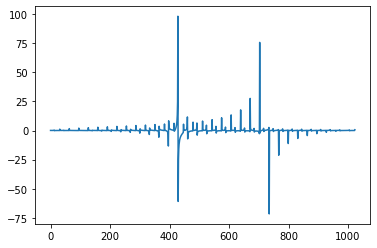

In [373]:
plt.plot(np.imag(np.fft.fft2(H)).flatten())

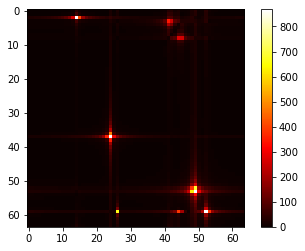

In [368]:
H_heat = np.abs(np.fft.fft2(H))
plt.imshow(H_heat, cmap=plt.cm.hot, vmin=0, vmax=H_heat.max()/3)
plt.colorbar()

In [254]:
np.abs(np.fft.fft2(H)).max()

777.0181903828078

In [255]:
np.abs(np.fft.fft2(H)).min()

0.313593491653471

In [287]:
import math
def pwr_normalize(sig):
    _, num_ele = sig.shape[0], torch.numel(sig[0])
    pwr_sig = torch.mean(torch.abs(sig)**2, dim=-1)
    print(pwr_sig)
    sig = sig/torch.sqrt(pwr_sig.unsqueeze(-1))
    return sig

def power_norm(signal, power=1):
    num_elements = len(signal.flatten())
    num_complex = num_elements//2//2
    temp = signal.view(num_complex, 2, 1, 2)
    signal_power = torch.mean(temp[:,0]**2+temp[:,1]**2)
    signal = signal * math.sqrt(power) / torch.sqrt(signal_power)
    return signal

def power_norm_batchwise(signal, power=1):
    batchsize , num_elements = signal.shape[0], len(signal[0].flatten())
    num_complex = num_elements//2
    signal_shape = signal.shape
    signal = signal.view(batchsize, num_complex, 2)
    signal_power = torch.mean((signal[:,:,0]**2 + signal[:,:,1]**2), dim=-1)

    print(signal_power)
    signal = signal * math.sqrt(power) / torch.sqrt(signal_power.unsqueeze(-1).unsqueeze(-1))
    signal = signal.view(signal_shape)
    return signal

In [289]:
A = torch.randn(40,6,2,2)     
B = torch.view_as_complex(A).view(40,-1)                     
# B = A.view(40,-1)
print(power_norm_batchwise(A)-torch.view_as_real(pwr_normalize(B)).view(40,6,2,2))

#print(power_norm_batchwise(A)-power_norm(A))

tensor([2.1421, 1.9866, 1.5828, 1.5390, 1.5544, 1.4398, 1.5712, 2.4064, 1.8379,
        2.2988, 2.1299, 1.6475, 1.5760, 1.8809, 2.0991, 1.7328, 2.1828, 2.0706,
        1.9512, 1.5043, 2.0690, 1.6861, 1.8449, 2.8848, 2.3115, 1.7430, 1.5835,
        1.9223, 2.8853, 2.8064, 2.6080, 2.6405, 3.2477, 1.2200, 1.6399, 2.7155,
        2.3207, 2.6729, 2.8254, 0.7554])
tensor([2.1421, 1.9866, 1.5828, 1.5390, 1.5544, 1.4398, 1.5712, 2.4064, 1.8379,
        2.2988, 2.1299, 1.6475, 1.5760, 1.8809, 2.0991, 1.7328, 2.1828, 2.0706,
        1.9512, 1.5043, 2.0690, 1.6861, 1.8449, 2.8848, 2.3115, 1.7430, 1.5835,
        1.9223, 2.8853, 2.8064, 2.6080, 2.6405, 3.2477, 1.2200, 1.6399, 2.7155,
        2.3207, 2.6729, 2.8254, 0.7554])
tensor([[[[ 0.0000e+00,  0.0000e+00],
          [ 0.0000e+00, -2.9802e-08]],

         [[-1.1921e-07,  0.0000e+00],
          [-1.4901e-08, -2.9802e-08]],

         [[-1.4901e-08,  0.0000e+00],
          [ 0.0000e+00, -5.9605e-08]],

         [[ 0.0000e+00,  0.0000e+00],
      

In [311]:
A = np.random.randint(0,10,(4,))
print(np.abs(A-5))
print(A.clamp(0,7))

[2 3 0 0]


AttributeError: 'numpy.ndarray' object has no attribute 'clamp'

In [343]:
import tqdm
import time
 
iter_object = range(10, 21)
pbar = tqdm.tqdm(iter_object,
                 total=len(iter_object),
                 colour="red")
 
for idx, element in enumerate(pbar):
    time.sleep(0.5)
    pbar.set_description(f"No.{idx}")
    pbar.set_postfix(f"正在处理的元素为 {element}")
    # pbar.set_postfix({"正在处理的元素为": element} )

Epoch 149/150: 100%|██████████████████| 150/150 [00:02<00:00, 66.39it/s, loss=8.00e+00, lo=8.00e+00]


In [404]:

A = torch.nn.NLLLoss()
x = torch.tensor([0.5,0.4,0.1])
print(x)
y = torch.tensor([0])

print(A(x.unsqueeze(0), y))

tensor([0.5000, 0.4000, 0.1000])
tensor(-0.5000)


In [394]:
math.log10(0.5)

-0.3010299956639812